In [1]:
!pip install -qq pyod
!pip install -qq ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.5/393.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
from google.colab import files
from sklearn.cluster import KMeans
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from scipy import stats
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set pandas display options to show real numbers
pd.set_option('display.float_format', '{:.2f}'.format)

Just stick to outlier detection different type of method please

# **1. Data Cleaning**



## A. Data Import

In [3]:
# Download latest version
path = kagglehub.dataset_download("mohammedarfathr/customer-transactions-dataset")

print("Path to dataset files:", path)

# Upload the file to Google Colab
uploaded = files. upload()

100%|██████████| 329k/329k [00:00<00:00, 26.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mohammedarfathr/customer-transactions-dataset/versions/1


Saving unclean_customer_data.csv to unclean_customer_data.csv


In [55]:
# Read the file
df = pd.read_csv("unclean_customer_data.csv")
df.head()

Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
0         8270 31.00       75851.59           77.10                  17   
1         1860 48.00       44460.18           61.35                  25   
2         6390 17.00       43677.76           22.59                   9   
3         6191 34.00       48666.81           82.07                   0   
4         6734 44.00       46080.33           65.08                   3   

   Transaction_Amount  
0              129.72  
1               91.48  
2              130.57  
3               72.40  
4              156.40

In [5]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         10200 non-null  int64  
 1   Age                 9943 non-null   float64
 2   Annual_Income       10200 non-null  float64
 3   Spending_Score      10200 non-null  float64
 4   Purchase_Frequency  10200 non-null  int64  
 5   Transaction_Amount  9944 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 478.3 KB


## B. Duplicated values

In [56]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Inspect duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]  # Keep all duplicates for inspection
duplicate_rows.sort_values(by='Customer_ID')  # Sort by a column for better readability

Number of duplicate rows: 200


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
8847          1011 44.00       56534.65           35.90                   7   
10029         1011 44.00       56534.65           35.90                   7   
10111         1058 55.00       40208.54           18.41                  22   
6743          1058 55.00       40208.54           18.41                  22   
9485          1095 36.00       41589.47           98.45                   5   
...            ...   ...            ...             ...                 ...   
799           9915   NaN       35121.44           63.85                  19   
10138         9946 23.00       59227.89           38.99                  23   
1512          9946 23.00       59227.89           38.99                  23   
1862          9984 49.00       59261.97           38.32                  27   
10106         9984 49.00       59261.97           38.32                  27   

       Transaction_Amount  
8847                52.15  
10029               52.15  
10111              108.64  
6743               108.64  
9485               111.66  
...                   ...  
799                118.97  
10138              134.51  
1512               134.51  
1862                68.54  
10106               68.54  

[400 rows x 6 columns]

- It can be noted that all the duplicate rows do not contain unique information; therefore, they should be removed.

In [57]:
# Drop duplicates
df.drop_duplicates(inplace=True)

## C. Missing values

In [58]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
missing_values


Missing values in each column:


Customer_ID             0
Age                   250
Annual_Income           0
Spending_Score          0
Purchase_Frequency      0
Transaction_Amount    250
dtype: int64

- `Age` and `Transaction_Amount` contain missing values.


In [59]:
# Find rows with missing values
rows_with_missing_values = df[df.isnull().any(axis=1)]

# Display rows with missing values
print("Rows with missing values:")
rows_with_missing_values

Rows with missing values:


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
12           7949 21.00       39844.81           19.51                   4   
54           4843   NaN       58748.89           17.07                   5   
70           5887 60.00       63505.85           60.21                   2   
77           3062 36.00       76245.40           59.59                  29   
94           4104   NaN       47228.29           69.81                  23   
...           ...   ...            ...             ...                 ...   
9893         9301   NaN       46593.42           19.57                   5   
9895         7194 42.00       25001.66           40.05                  14   
9973         1704   NaN       37713.03           97.81                   8   
9979         8519 33.00       61634.21           76.94                  17   
9983         4465 38.00       46400.59           89.35                   9   

      Transaction_Amount  
12                   NaN  
54                138.11  
70                   NaN  
77                   NaN  
94                 45.74  
...                  ...  
9893              136.67  
9895                 NaN  
9973              129.88  
9979                 NaN  
9983                 NaN  

[500 rows x 6 columns]

- The number of rows with missing values is small relative to the dataset.
- Based on the characteristics of the dataset, the missing values should not be filled because doing so could distort the data or introduce bias.

In [60]:
# Drop NaN
df = df.dropna()

## C. Data Quality

In [61]:
# Convert Age to Integer
df.loc[:,'Age'] = pd.to_numeric(df['Age'], errors='coerce').astype(int)

In [62]:
# Basic statistics
df.describe()

Customer_ID     Age  Annual_Income  Spending_Score  Purchase_Frequency  \
count      9500.00 9500.00        9500.00         9500.00             9500.00   
mean       5460.35   34.42       50121.78           50.74               14.50   
std        2592.30    9.96       14877.25           28.63                8.65   
min        1001.00    0.00      -17177.83            1.01                0.00   
25%        3202.25   28.00       39945.50           26.38                7.00   
50%        5481.50   34.00       50158.94           50.49               14.00   
75%        7696.25   41.00       60280.90           75.64               22.00   
max        9998.00   69.00      100836.69           99.99               29.00   

       Transaction_Amount  
count             9500.00  
mean               100.26  
std                 49.90  
min                -86.59  
25%                 66.23  
50%                100.12  
75%                134.08  
max                273.52

**Data Quality Issues:**  

- Negative values in `Annual_Income` and `Transaction_Amount` could happen due to typing errors. In most business contexts, negative transaction amounts are uncommon, as companies typically do not permit transactions that result in negative balances. Next, a customer cannot have a negative annual income, as this would imply having debt rather than earning income. Since annual income represents earnings, negative values are likely due to data entry errors.

- The `Age` column contains values under 18, which may suggest incorrect data or customers who are not the primary account holders.



In [63]:
# Filter rows where Age < 18
age_under18_rows = df[df['Age'] < 18]

# Display the filtered rows
print(f"Number of rows with Age < 18: {len(age_under18_rows)}")
print("Rows with Age under 18:")
age_under18_rows

Number of rows with Age < 18: 447
Rows with Age under 18:


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
2            6390 17.00       43677.76           22.59                   9   
13           3433 15.00       60950.54           85.95                   9   
48           4152 17.00       -1297.23           93.24                  20   
50           4943 13.00       35401.92           51.68                  20   
78           1064  8.00       29180.08           34.02                   1   
...           ...   ...            ...             ...                 ...   
9921         7539 14.00       59704.34           11.04                  15   
9952         7159 16.00       35595.58           39.55                  13   
9962         6594 17.00       68747.74           36.83                  15   
9978         1443 16.00       57187.49           18.06                  22   
9987         6588 16.00       36727.13           81.61                   4   

      Transaction_Amount  
2                 130.57  
13                 34.52  
48                102.83  
50                136.12  
78                183.19  
...                  ...  
9921               62.54  
9952               78.29  
9962               81.01  
9978              208.52  
9987              134.21  

[447 rows x 6 columns]

In [64]:
# Inspect rows with negative Annual_Income
negative_income_rows = df[df['Annual_Income'] < 0]
print(f"Number of rows with negative Annual_Income: {len(negative_income_rows)}")
print("Rows with negative Annual_Income:")
negative_income_rows

Number of rows with negative Annual_Income: 4
Rows with negative Annual_Income:


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
48           4152 17.00       -1297.23           93.24                  20   
2935         6184 42.00      -17177.83           53.38                  26   
4556         4861 24.00       -5328.01           31.65                  26   
8907         2941 37.00       -4114.98           88.03                  27   

      Transaction_Amount  
48                102.83  
2935                5.00  
4556              116.68  
8907              161.61

In [65]:
# Inspect rows with negative Transaction_Amount
negative_transaction_rows = df[df['Transaction_Amount'] < 0]
print(f"Number of rows with negative Transaction_Amount: {len(negative_transaction_rows)}")
print("Rows with negative Transaction_Amount:")
negative_transaction_rows

Number of rows with negative Transaction_Amount: 213
Rows with negative Transaction_Amount:


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
10           2685 18.00       64167.31            3.15                   2   
51           8555 39.00       59205.66           97.59                   7   
98           3731 43.00       39787.33           18.88                  17   
120          6116 47.00       49676.64           62.99                   4   
128          5636 26.00       57679.63           19.62                  12   
...           ...   ...            ...             ...                 ...   
9619         9823 31.00       60122.92           28.17                   8   
9741         5666 42.00       51392.40           38.99                   8   
9876         3416 45.00       34977.83           70.85                  24   
9919         9853 49.00       47890.04           44.68                  12   
9974         1825 47.00       64912.97           98.14                   2   

      Transaction_Amount  
10                 -0.82  
51                -23.22  
98                -22.86  
120                -0.21  
128                -1.67  
...                  ...  
9619               -2.20  
9741              -11.83  
9876               -2.84  
9919              -15.78  
9974              -32.86  

[213 rows x 6 columns]

- From the analysis in this subsection, to ensure data accuracy and consistency, **removing missing values** from the dataset is recommended.

- **Reasons for Removing Missing Values:**  
  - Customers under **18 years old** are less likely to have reliable `Annual_Income`, `Spending_Score`, `Purchase_Frequency`, or `Transaction_Amount` data.  
  - Including **negative income and transaction amounts** could distort the dataset, leading to artificially lower average values.



In [67]:
# Drop rows where Age < 18
df = df[df['Age'] >= 18]

# Drop negative values in Annual_Income and Transaction_Amount
df = df[(df['Annual_Income'] >= 0) & (df['Transaction_Amount'] >= 0)]

- After data cleaning, the dataset has been reduced from **10,200 entries to 8,843**, containing valid and meaningful data points for analysis.

# **2. Exploratory Data Analysis**



- At this stage, having a formal report that outlines data cleanliness, quality, and key statistics is beneficial. This is where the Profile Reporting tool comes in handy. **[ProfileReporting](https://docs.profiling.ydata.ai/latest/)** is a Python tool that helps to quickly generate an automated exploratory data analysis (EDA) report.

In [17]:
# Generate a profile report while ignoring 'Customer ID'
profile = ProfileReport(df.drop(columns=["Customer_ID"]))

# Save or display the report
profile.to_notebook_iframe()
profile.to_file("data_cleaning_report.html")  # Save as an HTML file

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

By observing the distribution of each variable, it can be said that `Spending_Score` and `Purchase_Frequency` exhibit a multimodal distribution, indicating the presence of multiple customer behavior patterns. Additionally, there is no correlation among variables.

## B. Outlier Detection

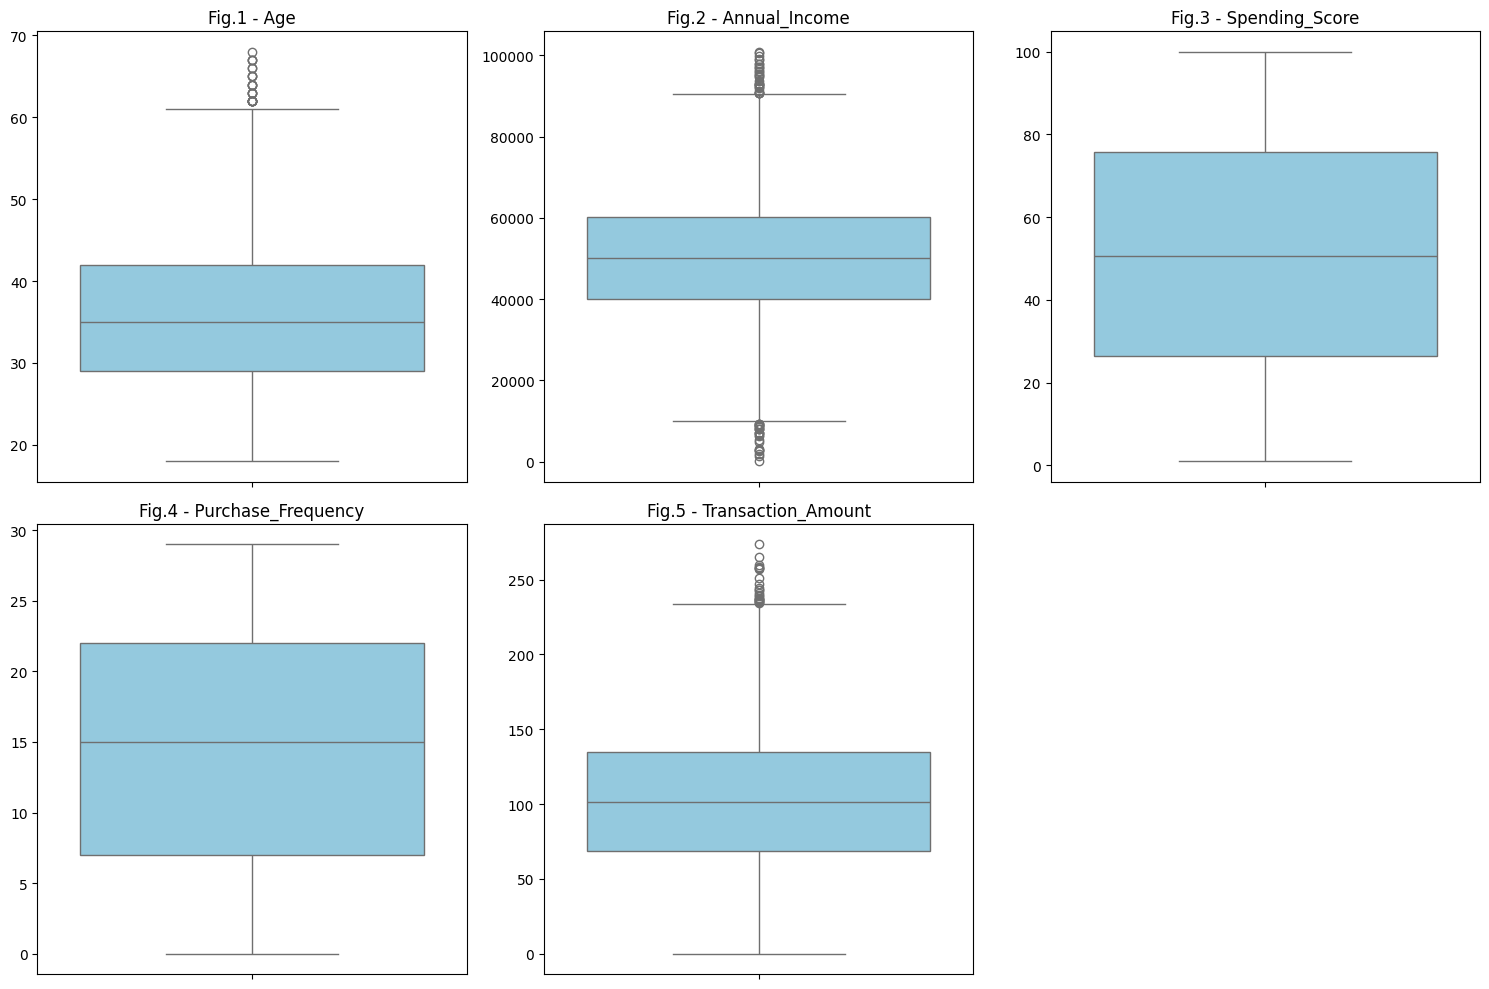

In [68]:
# Set up the figure and axes
plt.figure(figsize=(15, 10))

# List of columns to plot
columns = df.drop(columns=['Customer_ID']).columns

# Create boxplots for each numerical column
for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Fig.{i} - {col}", fontsize=12)
    plt.ylabel('')  # Remove y-axis label for cleaner look

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- According to the box plot, two columns (`Annual_Income` and `Transaction_Amount`) contain numerous outliers, which are data points that fall significantly outside the range of the rest of the data.



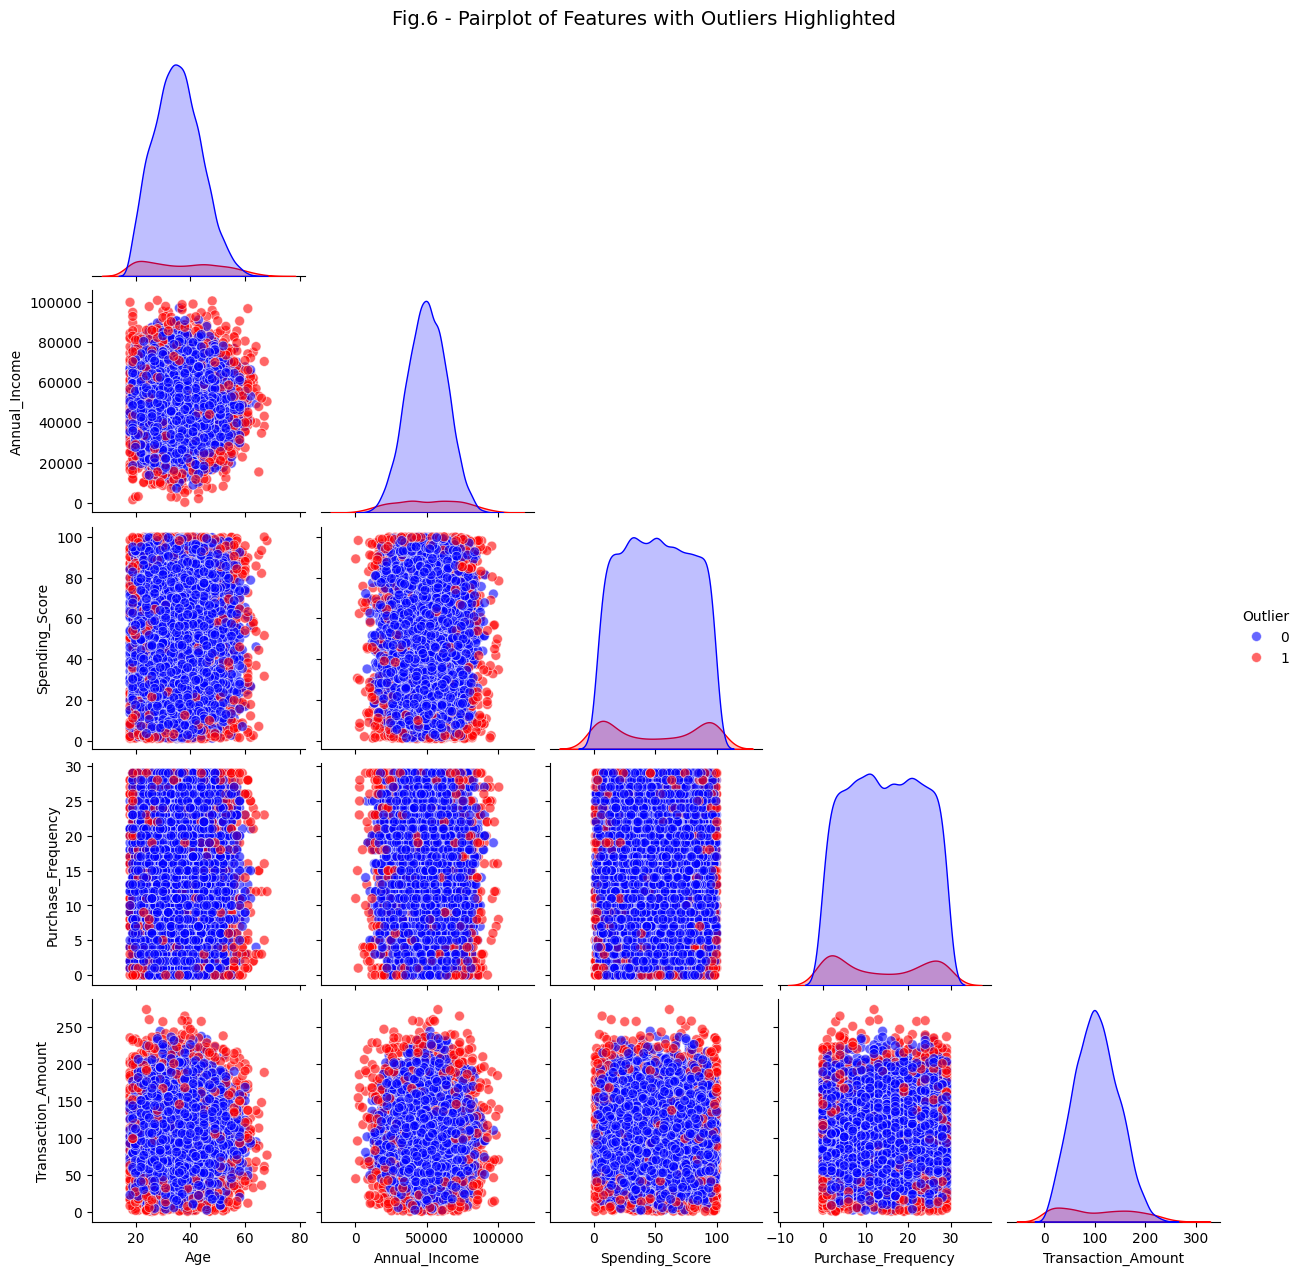

In [78]:
# Drop irrelevant columns
X = df.drop(columns=["Customer_ID"])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the ECOD model
ecod = ECOD()

# Fit the model on the scaled data
ecod.fit(X_scaled)

# Predict outliers (1 for outliers, 0 for inliers)
outliers = ecod.predict(X_scaled)

# Add the outlier predictions to the DataFrame
df['Outlier'] = outliers

# Pairplot visualization
sns.pairplot(
    data=df.drop(columns=["Customer_ID"]),  # Drop Customer_ID, keep Outlier for hue
    vars=df.drop(columns=["Customer_ID", "Outlier"]).columns,  # Use all columns except Customer_ID and Outlier
    diag_kind="kde",  # Use KDE for diagonal plots
    corner=True,  # Show only lower triangle of the pairplot
    hue="Outlier",  # Color by outlier status
    palette={0: "blue", 1: "red"},  # Blue = normal, Red = outlier
    plot_kws={"alpha": 0.6, "s": 50},  # Transparency and size for scatter plots
    height=2.5  # Adjust height of each subplot
)

plt.suptitle("Fig.6 - Pairplot of Features with Outliers Highlighted", y=1.02, fontsize=14)
plt.show()

In [33]:
# Count the number of outliers
num_outliers = df[df['Outlier'] == 1].shape[0]

# Print the result
print(f"Number of outliers detected: {num_outliers}")

Number of outliers detected: 885


## C. Outlier Removal

In [34]:
# Filter and display df without outliers
no_outliers_df = df[df['Outlier'] == 0]
no_outliers_df = no_outliers_df.drop(columns="Outlier")
print("Data Without Outliers:")
no_outliers_df

Data Without Outliers:


Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
0            8270 31.00       75851.59           77.10                  17   
1            1860 48.00       44460.18           61.35                  25   
3            6191 34.00       48666.81           82.07                   0   
4            6734 44.00       46080.33           65.08                   3   
5            7265 41.00       23764.21           22.90                  28   
...           ...   ...            ...             ...                 ...   
9994         5215 29.00       53689.57           35.97                  22   
9995         1581 36.00       52367.41           56.14                   8   
9996         4881 39.00       22129.59           87.49                  10   
9997         4909 40.00       70678.68           78.37                   2   
9999         1400 19.00       48401.66           82.70                  13   

      Transaction_Amount  
0                 129.72  
1                  91.48  
3                  72.40  
4                 156.40  
5                  63.79  
...                  ...  
9994               82.98  
9995               52.49  
9996              154.56  
9997              105.55  
9999              125.94  

[7958 rows x 6 columns]

# 3. Analyze Spending Behavior

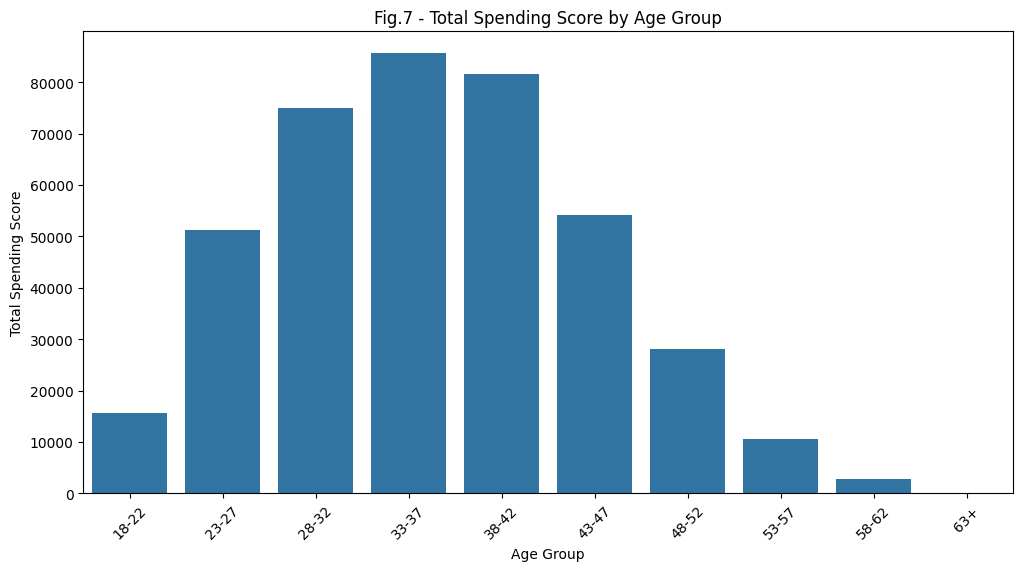

In [80]:
# Define more granular age bins and labels
bins = [18, 22, 27, 32, 37, 42, 47, 52, 57, 62, 63]
labels = ['18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48-52', '53-57', '58-62', '63+']

# Create age group column with more granular age bins
no_outliers_df['Age_Group'] = pd.cut(no_outliers_df['Age'], bins=bins, labels=labels, right=False)

# Calculate mean spending score by more granular age group
spending_score_by_age_group = no_outliers_df.groupby('Age_Group', observed=True)['Spending_Score'].sum()

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x=spending_score_by_age_group.index, y=spending_score_by_age_group.values)
plt.title('Fig.7 - Total Spending Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Spending Score')
plt.xticks(rotation=45)
plt.show()

**A Summary of Total Spending Score by Age Group**  

- **Younger Age Groups (18-42)**:  
  - The **18-22** group has a total spending score of **15,580.77**, which increases significantly in the **23-27** group (**51,273.05**) and continues to rise in the **28-32** group (**74,982.06**), reaching its peak in the **33-37** group (**85,589.85**).  
  - Spending remains relatively high in the **38-42** group (**81,681.08**), suggesting that individuals in their 20s and 30s, as well as early 40s, are the most active spenders.  

- **Mid-age Groups (43-57)**:  
  - The spending score starts to decline after the **38-42** group, dropping to **54,203.96** in the **43-47** group and further to **28,066.07** in the **48-52** group.  
  - A more noticeable decline occurs in the **53-57** group (**10,577.44**), suggesting a shift in spending habits as people move into their 50s.  

- **Older Age Groups (58+)**:  
  - The decline becomes sharper in the **58-62** group (**2,758.81**) and reaches its lowest point in the **63+** group (**161.89**), reflecting a significant reduction in spending, likely due to retirement.

**Conclusion:**  
The highest total spending scores occur in the **33-37** age range, with strong spending activity in the late 20s to early 40s. However, spending begins to decline steadily after age 42, with a **sharp drop after 52**, especially in the late 50s and beyond.

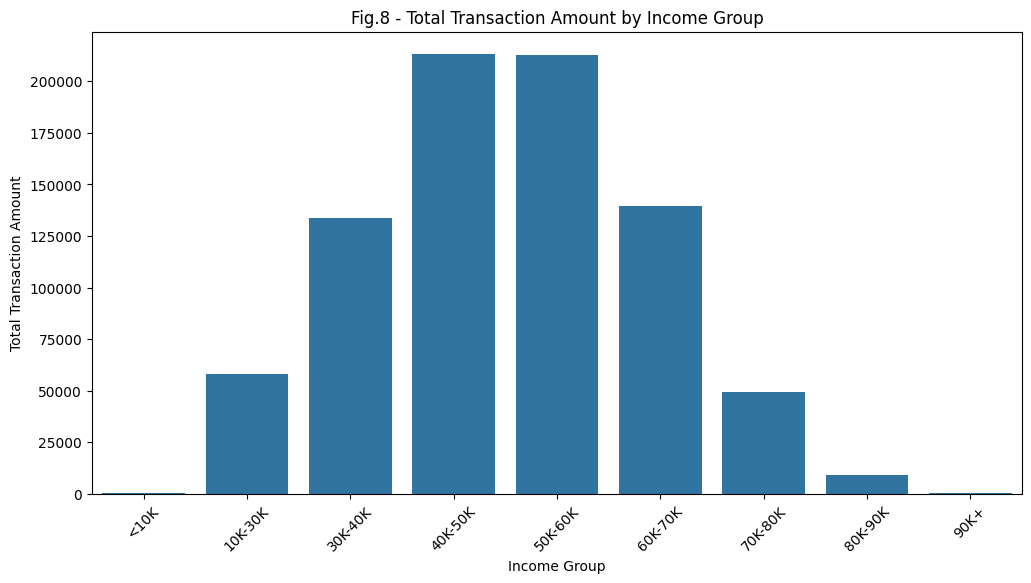

In [96]:
# Define more granular income bins and labels
income_bins = [0, 10000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
income_labels = [
    '<10K', '10K-30K', '30K-40K', '40K-50K', '50K-60K',
    '60K-70K', '70K-80K', '80K-90K', '90K+'
]  # 9 labels

# Create income group column
no_outliers_df['Income_Group'] = pd.cut(no_outliers_df['Annual_Income'], bins=income_bins, labels=income_labels, right=False)

# Calculate total transaction amount by income group
transaction_amount_by_income_group = no_outliers_df.groupby('Income_Group', observed=True)['Transaction_Amount'].sum()

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=transaction_amount_by_income_group.index, y=transaction_amount_by_income_group.values)
plt.title('Fig.8 - Total Transaction Amount by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Total Transaction Amount')
plt.xticks(rotation=45)
plt.show()


**An Analysis of Total Transaction Amount by Income Group**  

- **Lower Income Brackets (`<10K` - `30K-40K`)**:  
  - Individuals earning** less than 10K** contribute very little (**253.72**) to total transactions.  
  - The **10K-30K** group sees a sharp rise (**58,013.61**), followed by significant jump in the** 30K-40K** group (**133,773.13**).  

- **Middle Income Brackets (`40K-70K`)**:  
  - Peak spending occurs in the **40K-50K** group (**213,383.12**), nearly doubling the previous bracket.  
  - The **50K-60K** group maintains a similar spending level (**213,017.18**), indicating that transaction amounts remain high for mid-income earners.  
  - A decline starts in the **60K-70K** group (**139,735.96**), suggesting diminishing spending power beyond this point.  

- **Higher Income Brackets (`70K+`)**:  
  - The **70K-80K** group spends significantly less (**49,148.26**), confirming a downward trend.  
  - **80K-90K** shows a sharp drop (**9,088.73**), indicating that high-income earners contribute less to total transaction volume.  
  - The **90K+ group** barely contributes (**539.24**), possibly due to different spending habits.




The below Figure displays the relationship between Age and Income Group, with the size and color of each point representing the Transaction Amount.

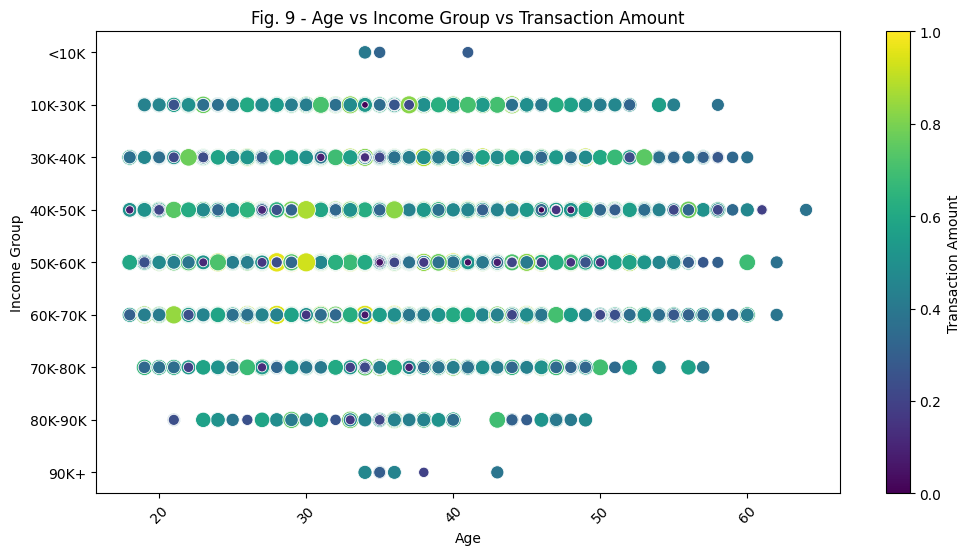

In [97]:
# Create a scatter plot where x = Age, y = Income_Group, and color/size represents Transaction Amount
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=no_outliers_df, x='Age', y='Income_Group', size='Transaction_Amount', hue='Transaction_Amount', palette='viridis', sizes=(20, 200), legend=False)

# Add a color bar
plt.colorbar(scatter.collections[0], label='Transaction Amount')

plt.title('Fig. 9 - Age vs Income Group vs Transaction Amount')
plt.xlabel('Age')
plt.ylabel('Income Group')
plt.xticks(rotation=45)
plt.show()
